# Lecture 5: Model Evaluation and Types of data fitting

MTU Spring 2025

Instructor: Amna Mazen

### Learning outcomes

From this lecture, students are expected to be able to:

- Explain why accuracy is not always the best metric in ML.
- Explain components of a confusion matrix.
- Define precision, recall, and f1-score and use them to evaluate different classifiers.
- Broadly explain macro-average, weighted average.


### Imports

In [ ]:
import os
import sys

sys.path.append("code/.")

import IPython
import matplotlib.pyplot as plt
#import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
#from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


#from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

from IPython.display import Image

In [ ]:
# Changing global matplotlib settings for confusion matrix.
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

## Evaluation metrics for binary classification: Motivation

 Let's classify fraudulent and non-fraudulent transactions using Kaggle's [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) data set.

In [ ]:
cc_df = pd.read_csv("/content/creditcard.csv", encoding="latin-1")
cc_df=cc_df.dropna(axis=0)
train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)
train_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
64454,51150.0,-3.538816,3.481893,-1.827130,-0.573050,2.644106,-0.340988,2.102135,-2.939006,2.578654,...,0.530978,-0.860677,-0.201810,-1.719747,0.729143,-0.547993,-0.023636,-0.454966,1.00,0
37906,39163.0,-0.363913,0.853399,1.648195,1.118934,0.100882,0.423852,0.472790,-0.972440,0.033833,...,0.687055,-0.094586,0.121531,0.146830,-0.944092,-0.558564,-0.186814,-0.257103,18.49,0
79378,57994.0,1.193021,-0.136714,0.622612,0.780864,-0.823511,-0.706444,-0.206073,-0.016918,0.781531,...,-0.310405,-0.842028,0.085477,0.366005,0.254443,0.290002,-0.036764,0.015039,23.74,0
245686,152859.0,1.604032,-0.808208,-1.594982,0.200475,0.502985,0.832370,-0.034071,0.234040,0.550616,...,0.519029,1.429217,-0.139322,-1.293663,0.037785,0.061206,0.005387,-0.057296,156.52,0
60943,49575.0,-2.669614,-2.734385,0.662450,-0.059077,3.346850,-2.549682,-1.430571,-0.118450,0.469383,...,-0.228329,-0.370643,-0.211544,-0.300837,-1.174590,0.573818,0.388023,0.161782,57.50,0


### Dataset preprocessing


In [ ]:
train_df.shape

(199364, 31)

- Good size dataset
- For confidentially reasons, it only provides transformed features with PCA, which is a popular dimensionality reduction technique.

- We do not have categorical features. All features are numeric.
- We have to be careful about the `Time` and `Amount` features.
- We could scale `Amount`.
- Do we want to scale time?
    - In this lecture, we'll just drop the Time feature.
    - We'll learn about time series briefly later in the course.

Let's separate `X` and `y` for train and test splits.

In [ ]:
X_train_big, y_train_big = train_df.drop(columns=["Class", "Time"]), train_df["Class"]
X_test, y_test = test_df.drop(columns=["Class", "Time"]), test_df["Class"]

- It's easier to demonstrate evaluation metrics using an explicit validation set instead of using cross-validation.
- So let's create a validation set.
- Our data is large enough so it shouldn't be a problem.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_big, y_train_big, test_size=0.3, random_state=123
)

#### Baseline

In [ ]:
dummy = DummyClassifier()
pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True)).mean()

,0
fit_time,0.018061
score_time,0.002517
test_score,0.998302
train_score,0.998302


#### Observations

- `DummyClassifier` is getting 0.998 cross-validation accuracy!!
- Should we be happy with this accuracy and deploy this `DummyClassifier` model for fraud detection?

What's the class distribution?

In [ ]:
train_df["Class"].value_counts(normalize=True)

,proportion
Class,
0,0.9983
1,0.0017


- We have class imbalance.
- We have MANY non-fraud transactions and only a handful of fraud transactions.
- So in the training set, `most_frequent` strategy is labeling 199,025 (99.83%) instances correctly and only 339 (0.17%) instances incorrectly.
- Is this what we want?
- The "fraud" class is the important class that we want to spot.

Let's scale the features and try `LogisticRegression`.   

In [ ]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True)).mean()

,0
fit_time,0.398167
score_time,0.011006
test_score,0.999183
train_score,0.999221


- We are getting a slightly better score with logistic regression.  
- What score should be considered an acceptable score here?
- Are we actually spotting any "fraud" transactions?

- `.score` by default returns accuracy which is
$$\frac{\text{correct predictions}}{\text{total examples}}$$
- Is accuracy a good metric here?
- Is there anything more informative than accuracy that we can use here?

Let's dig a little deeper.

## Confusion matrix

One way to get a better understanding of the errors is by looking at
- false positives (type I errors), where the model incorrectly spots examples as fraud
- false negatives (type II errors), where it's missing to spot fraud examples

You can get a numpy array of confusion matrix as follows:

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = pipe.predict(X_valid)
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
print("Confusion matrix for fraud data set")
print(disp.confusion_matrix)

Confusion matrix for fraud data set
[[59700     8]
 [   38    64]]


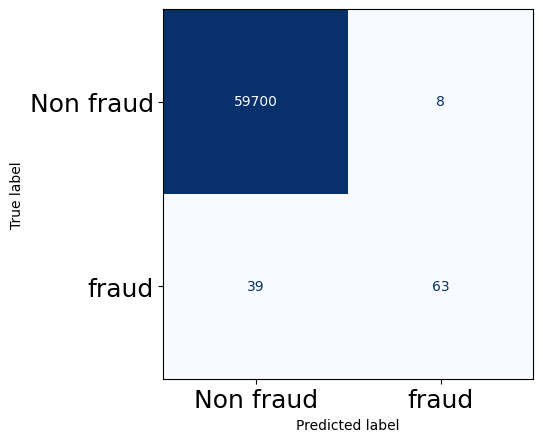

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

pipe.fit(X_train, y_train)
disp = ConfusionMatrixDisplay.from_estimator(
    pipe,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
    colorbar=False,
);

![image.png](attachment:image.png)

- Perfect prediction has all values down the diagonal
- Off diagonal entries can often tell us about what is being mis-predicted

### What is "positive" and "negative"?

- Two kinds of binary classification problems
    - Distinguishing between two classes
    - Spotting a class (spot fraud transaction, spot spam, spot disease)
- In case of spotting problems, the thing that we are interested in spotting is considered "positive".
- Above we wanted to spot fraudulent transactions and so they are "positive".

### Confusion matrix with cross-validation

- You can also calculate confusion matrix with cross-validation using the `cross_val_predict` method.  
- But then you cannot conveniently use `plot_confusion_matrix`.

In [ ]:
from sklearn.model_selection import cross_val_predict

confusion_matrix(y_train, cross_val_predict(pipe, X_train, y_train))

array([[139296,     21],
       [    94,    143]], dtype=int64)

## Precision, recall, f1 score

- We have been using `.score` to assess our models, which returns accuracy by default.
- Accuracy is misleading when we have class imbalance.
- We need other metrics to assess our models.

- We'll discuss three commonly used metrics which are based on confusion matrix:
    - precision
    - recall
    - f1 score
- Note that these metrics will only help us assessing our model.  
- Later we'll talk about a few ways to address class imbalance problem.

In [ ]:
from sklearn.metrics import confusion_matrix

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr.fit(X_train, y_train)
predictions = pipe_lr.predict(X_valid)
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
print(disp.confusion_matrix)

[[59700     8]
 [   38    64]]


### Manual Calculation

#### Precision

Among the positive examples you identified, how many were actually positive?

$$ precision = \frac{TP}{TP+FP}$$

In [ ]:
print("TP = %0.4f, FP = %0.4f" % (TP, FP))
precision = TP / (TP + FP)
print("Precision: %0.4f" % (precision))

TP = 64.0000, FP = 8.0000
Precision: 0.8889


#### Recall

Among all positive examples, how many did you identify?
$$ recall = \frac{TP}{TP+FN} = \frac{TP}{\#positives} $$

In [ ]:
print("TP = %0.4f, FN = %0.4f" % (TP, FN))
recall = TP / (TP + FN)
print("Recall: %0.4f" % (recall))

TP = 64.0000, FN = 38.0000
Recall: 0.6275


#### F1-score

- F1-score combines precision and recall to give one score, which could be used in hyperparameter optimization, for instance.
- F1-score is a harmonic mean of precision and recall.


$$ f1 = 2 \times \frac{ precision \times recall}{precision + recall}$$


In [ ]:
print("precision: %0.4f" % (precision))
print("recall: %0.4f" % (recall))
f1_score = (2 * precision * recall) / (precision + recall)
print("f1: %0.4f" % (f1_score))

precision: 0.8889
recall: 0.6275
f1: 0.7356


Let's look at all metrics at once on our dataset.

In [ ]:
## Calculate evaluation metrics by ourselves
data = {
    "calculation": [],
    "accuracy": [],
    "error": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
}
data["calculation"].append("manual")
data["accuracy"].append((TP + TN) / (TN + FP + FN + TP))
data["error"].append((FP + FN) / (TN + FP + FN + TP))
data["precision"].append(precision)  # TP / (TP + FP)
data["recall"].append(recall)  # TP / (TP + FN)
data["f1 score"].append(f1_score)  # (2 * precision * recall) / (precision + recall)
df = pd.DataFrame(data)
df

,calculation,accuracy,error,precision,recall,f1 score
0,manual,0.999231,0.000769,0.888889,0.627451,0.735632


 ### [Using `scikit-learn` Functions](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

data["accuracy"].append(accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["error"].append(1 - accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["precision"].append(
    precision_score(y_valid, pipe_lr.predict(X_valid), zero_division=1)
)
data["recall"].append(recall_score(y_valid, pipe_lr.predict(X_valid)))
data["f1 score"].append(f1_score(y_valid, pipe_lr.predict(X_valid)))
data["calculation"].append("sklearn")
df = pd.DataFrame(data)
df.set_index(["calculation"])

,accuracy,error,precision,recall,f1 score
calculation,,,,,
manual,0.999231,0.000769,0.888889,0.627451,0.735632
sklearn,0.999231,0.000769,0.888889,0.627451,0.735632


### Classification report

- There is a convenient function called `classification_report` in `sklearn` which gives this info.

In [ ]:
pipe_lr.classes_

array([0, 1], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_valid, pipe_lr.predict(X_valid), target_names=["non-fraud", "fraud"]
    )
)

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



### 🎯 Class Activity: Think-Pair-Share (TPS)
Discuss with a partner: What do "Macro Average" and "Weighted Average" represent in the classification report generated by Scikit-Learn?

### Insights:

- Accuracy is misleading when you have class imbalance.
- A confusion matrix provides a way to break down errors made by our model.
- We looked at three metrics based on confusion matrix:
    - precision, recall, f1-score.

- Note that what you consider "positive" (fraud in our case) is important when calculating precision, recall, and f1-score.
- If you flip what is considered positive or negative, we'll end up with different TP, FP, TN, FN, and hence different precision, recall, and f1-scores.

## Regression Evaluation metrics

- We aren't doing classification anymore, so we can't just check for equality:

### Dataset

In this lecture, we'll be using [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/). As usual, to run this notebook you'll need to download the data. For this dataset, train and test have already been separated. We'll be working with the train portion in this lecture.

In [ ]:
df = pd.read_csv("data/housing-kaggle/train.csv")
train_df, test_df = train_test_split(df, test_size=0.10, random_state=123)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
767,768,50,RL,75.0,12508,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,1300,7,2008,WD,Normal,160000
429,430,20,RL,130.0,11457,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,175000
1139,1140,30,RL,98.0,8731,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,144000
558,559,60,RL,57.0,21872,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,175000


- The supervised machine learning problem is predicting housing price given features associated with properties.
- Here, the target is `SalePrice`, which is continuous. So it's a **regression problem** (as opposed to classification).

### Preprocessing Steps

In [ ]:
train_df.shape

(1314, 81)

#### Let's separate `X` and `y`

In [ ]:
X_train = train_df.drop(columns=["SalePrice"])
y_train = train_df["SalePrice"]

X_test = test_df.drop(columns=["SalePrice"])
y_test = test_df["SalePrice"]

#### EDA


In [ ]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1314.000000,1314.000000,1089.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1307.000000,1314.000000,...,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,734.182648,56.472603,69.641873,10273.261035,6.076104,5.570015,1970.995434,1984.659056,102.514155,441.425419,...,94.281583,45.765601,21.726788,3.624049,13.987062,3.065449,46.951294,6.302131,2007.840183,179802.147641
std,422.224662,42.036646,23.031794,8997.895541,1.392612,1.112848,30.198127,20.639754,178.301563,459.276687,...,125.436492,65.757545,60.766423,30.320430,53.854129,42.341109,522.283421,2.698206,1.332824,79041.260572
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,369.250000,20.000000,59.000000,7500.000000,5.000000,5.000000,1953.000000,1966.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129600.000000
50%,735.500000,50.000000,69.000000,9391.000000,6.000000,5.000000,1972.000000,1993.000000,0.000000,376.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162000.000000
75%,1099.750000,70.000000,80.000000,11509.000000,7.000000,6.000000,2000.000000,2004.000000,165.500000,704.750000,...,168.000000,66.750000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,212975.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1314 entries, 302 to 1389
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1314 non-null   int64  
 1   MSSubClass     1314 non-null   int64  
 2   MSZoning       1314 non-null   object 
 3   LotFrontage    1089 non-null   float64
 4   LotArea        1314 non-null   int64  
 5   Street         1314 non-null   object 
 6   Alley          81 non-null     object 
 7   LotShape       1314 non-null   object 
 8   LandContour    1314 non-null   object 
 9   Utilities      1314 non-null   object 
 10  LotConfig      1314 non-null   object 
 11  LandSlope      1314 non-null   object 
 12  Neighborhood   1314 non-null   object 
 13  Condition1     1314 non-null   object 
 14  Condition2     1314 non-null   object 
 15  BldgType       1314 non-null   object 
 16  HouseStyle     1314 non-null   object 
 17  OverallQual    1314 non-null   int64  
 18  Overal

#### Feature types

- We have mixed feature types and a bunch of missing values.
- Now, let's identify feature types and transformations.

- Let's get the numeric-looking columns.

In [ ]:
numeric_looking_columns = X_train.select_dtypes(include=np.number).columns.tolist()
print(numeric_looking_columns)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


Not all numeric looking columns are necessarily numeric.

In [ ]:
train_df["MSSubClass"].unique()

array([ 20,  50,  30,  60, 160,  85,  90, 120, 180,  80,  70,  75, 190,
        45,  40], dtype=int64)

MSSubClass: Identifies the type of dwelling involved in the sale.

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

Also, month sold is more of a categorical feature than a numeric feature.

In [ ]:
train_df["MoSold"].unique() # Month Sold

array([ 1,  7,  3,  5,  8, 10,  6,  9, 12,  2,  4, 11], dtype=int64)

In [ ]:
drop_features = ["Id"]
numeric_features = [
    "BedroomAbvGr",
    "KitchenAbvGr",
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold",
]

In [ ]:
set(numeric_looking_columns) - set(numeric_features) - set(drop_features)

{'MSSubClass', 'MoSold'}

We'll treat the above numeric-looking features as categorical features.

- There are a bunch of ordinal features in this dataset.
- Ordinal features with the same scale
    - Poor (Po), Fair (Fa), Typical (TA), Good (Gd), Excellent (Ex)
    - These we'll be calling `ordinal_features_reg`.
- Ordinal features with different scales
    - These we'll be calling `ordinal_features_oth`.

In [ ]:
ordinal_features_reg = [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PoolQC",
]
ordering = [
    "Po",
    "Fa",
    "TA",
    "Gd",
    "Ex",
]  # if N/A it will just impute something, per below
ordering_ordinal_reg = [ordering] * len(ordinal_features_reg)
ordering_ordinal_reg

[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex']]

We'll pass the above as categories in our `OrdinalEncoder`.

- There are a bunch more ordinal features using different scales.
  - These we'll be calling `ordinal_features_oth`.
  - We are encoding them separately.

In [ ]:
ordinal_features_oth = [
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "Fence",
]
ordering_ordinal_oth = [
    ['NA', 'No', 'Mn', 'Av', 'Gd'],
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],
    ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
]

The remaining features are categorical features.

In [ ]:
categorical_features = list(
    set(X_train.columns)
    - set(numeric_features)
    - set(ordinal_features_reg)
    - set(ordinal_features_oth)
    - set(drop_features)
)
categorical_features

['Heating',
 'CentralAir',
 'MoSold',
 'LotShape',
 'RoofStyle',
 'SaleCondition',
 'Street',
 'Exterior2nd',
 'LandSlope',
 'LotConfig',
 'MSSubClass',
 'Alley',
 'RoofMatl',
 'Foundation',
 'Utilities',
 'MSZoning',
 'Condition1',
 'Condition2',
 'Exterior1st',
 'Neighborhood',
 'SaleType',
 'MiscFeature',
 'HouseStyle',
 'MasVnrType',
 'GarageFinish',
 'PavedDrive',
 'Electrical',
 'GarageType',
 'LandContour',
 'BldgType']

- We are not doing it here but we can engineer our own features too.
- Would price per square foot be a good feature to add in here?

#### Applying feature transformations

- Since we have mixed feature types, let's use `ColumnTransformer` to apply different transformations on different features types.  

In [ ]:
from sklearn.compose import ColumnTransformer, make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
ordinal_transformer_reg = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_reg),
)

ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_reg, ordinal_features_reg),
    (ordinal_transformer_oth, ordinal_features_oth),
    (categorical_transformer, categorical_features),
)

In [ ]:
preprocessor.fit(X_train) # Calling fit to examine all the transformers.
preprocessor.named_transformers_

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


{'drop': 'drop',
 'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                      

In [ ]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
)
new_columns = numeric_features + ordinal_features_reg + ordinal_features_oth + ohe_columns

In [ ]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)
X_train_enc.head()

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType_missing,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE
302,0.154795,-0.222647,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
767,1.372763,-0.222647,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
429,0.154795,-0.222647,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1139,0.154795,-0.222647,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
558,0.154795,-0.222647,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Other possible preprocessing?  

- There is a lot of room for improvement ...
- We're just using `SimpleImputer`.
    - In reality we'd want to go through this more carefully.
    - We may also want to drop some columns that are almost entirely missing.    
- We could also check for outliers, and do other exploratory data analysis (EDA).
- But for academic purposes, this is good enough ...    

#### `DummyRegressor`

In [ ]:
dummy = DummyRegressor()
pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.000999,0.000000,-0.003547,0.0
1,0.000999,0.000000,-0.001266,0.0
2,0.001001,0.000000,-0.011767,0.0
3,0.000998,0.000000,-0.006744,0.0
4,0.000000,0.001001,-0.076533,0.0
5,0.001001,0.000000,-0.003133,0.0
6,0.001000,0.000000,-0.000397,0.0
7,0.001000,0.000000,-0.003785,0.0
8,0.001000,0.000000,-0.001740,0.0
9,0.000999,0.000000,-0.000117,0.0


#### `LinearRegression()`

Ordinary least squares Linear Regression.

- LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [ ]:
lr_pipe = make_pipeline(preprocessor, LinearRegression())
pd.DataFrame(cross_validate(lr_pipe, X_train, y_train, cv=10, return_train_score=True))

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse

,fit_time,score_time,test_score,train_score
0,0.145145,0.012001,-1.909981e+16,0.925595
1,0.138000,0.011000,-4.241646e+17,0.925987
2,0.132000,0.012000,-9.787982e+17,0.930772
3,0.137002,0.012004,8.685904e-01,0.924401
4,0.135995,0.011000,-3.614989e+16,0.930455
5,0.135002,0.015000,-7.891841e+18,0.921917
6,0.144000,0.010999,8.410984e-01,0.926939
7,0.135997,0.012004,-3.930159e+16,0.923892
8,0.145001,0.011000,-3.327886e+17,0.924451
9,0.135999,0.014000,-1.403822e+19,0.921558


In [ ]:
lr_pipe.fit(X_train, y_train)

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['Id']),
                                                 ('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'Bs...
                                                   'RoofStyle', 'SaleCondition',
                                                   'Street', 'Exterior2nd',
                                                   'LandSlope', 'LotConfig',
                                                   'MSSubClass', 'Alley',
                                                   'RoofMatl', 'Foundation',
                                                   'Utilities', 'MSZoning',
                                                   'Condition1', 'Condition2',
                                                   'Exterior1st',
                                                   'Neighborhood', 'SaleType',
                                                   'MiscFeature', 'HouseStyle',
                                                   'MasVnrType', 'GarageFinish',
                                                   'PavedDrive', 'Electrical',
                                                   'GarageType', 'LandContour',
                                                   'BldgType'])])),
                ('linearregression', LinearRegression())])

In [ ]:
lr_preds=lr_pipe.predict(X_train)
lr_preds

array([208052., 166204., 194596., ..., 265618., 120056., 132812.])

In [ ]:
lr_pipe.predict(X_train) == y_train

302     False
767     False
429     False
1139    False
558     False
        ...  
1041    False
1122    False
1346    False
1406    False
1389    False
Name: SalePrice, Length: 1314, dtype: bool

In [ ]:
y_train.values

array([205000, 160000, 175000, ..., 262500, 133000, 131000], dtype=int64)

We need a score that reflects how right/wrong each prediction is.

### Regression model Evaluation metrics

Here you have a number of popular scoring functions for regression. We are going to look at some common metrics:

- mean squared error (MSE)
- root mean squared error (RMSE)
- MAPE
- $R^2$

See [sklearn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) for more details.

### Mean squared error (MSE)

- A common metric is mean squared error:

In [ ]:
preds = lr_pipe.predict(X_train)

In [ ]:
np.mean((y_train - preds) ** 2)

485633899.21156776

This is also implemented in sklearn:

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, preds)

485633899.21156776

- MSE looks huge and unreasonable.
- Is this score good or bad?

- Unlike classification, with regression **our target has units**.
- The target is in dollars, the mean squared error is in $dollars^2$
- The score also depends on the scale of the targets.
- If we were working in cents instead of dollars, our MSE would be $10,000 \times (100^2$) higher!

In [ ]:
np.mean((y_train * 100 - preds * 100) ** 2)

4856338992115.678

### Root mean squared error or RMSE

- The MSE above is in $dollars^2$.
- A more relatable metric would be the root mean squared error, or RMSE

In [ ]:
np.sqrt(mean_squared_error(y_train, lr_pipe.predict(X_train)))

22037.102786245923

- Error of \$22,000 makes more sense.
- Can we dig deeper?

- Here we can see a few cases where our prediction is way off.
- Is there something weird about those houses, perhaps? Outliers?
- Under the line means we're under-prediction, over the line means we're over-predicting.

### MAPE (Mean absolute percentage error)

- We got an RMSE of ~$22,000 before.

Question: Is an error of \$22,000 acceptable?

In [ ]:
np.sqrt(mean_squared_error(y_train, lr_pipe.predict(X_train)))

22037.102786245923

- For a house worth \$600k, it seems reasonable! That's 3.5% error.
- For a house worth \$60k, that is terrible. It's 35% error.

We have both of these cases in our dataset.

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
mean_absolute_percentage_error(y_train, pred_train)

0.0885614397286022

### $R^2$ (not in detail)

A common score is the $R^2$, AKA Coefficient of determination

- This is the score that `sklearn` uses by default when you call score():
- You can [read about it](https://en.wikipedia.org/wiki/Coefficient_of_determination) if interested.
- Intuition: similar to mean squared error, but flipped (higher is better), and normalized so the max is 1.
- Is a statistical measure that represents the goodness of fit of a regression model.
- 1 when the model perfectly fits the data and there is no difference between the predicted value and actual value.

$$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y_i})^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$$

Key points:
- The maximum is 1 for perfect predictions
- Negative values are very bad: "worse than DummyRegressor" (very bad)


(optional) Warning: MSE is "reversible" but $R^2$ is not:

In [ ]:
mean_squared_error(preds, y_train)

485633899.21156776

In [ ]:
r2_score(y_train, preds)

0.9222085407989993

In [ ]:
r2_score(preds, y_train)

0.9156801484036222

- When you call `fit` it minimizes MSE / maximizes $R^2$ (or something like that) by default.
- Just like in classification, this isn't always what you want!!

##  Segmentation IoU (Intersection over Union)


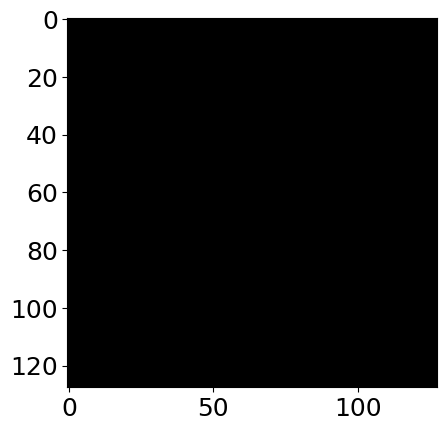

In [ ]:
zeros_array = np.zeros((128, 128, 1), dtype=np.int8)
plt.imshow(zeros_array, 'gray')

In [ ]:
pred=np.load('data/prediction_sample.npy')
label=np.load('data/test_sample.npy')
img=np.load('data/testInput_sample.npy')

In [ ]:
zeros_array.shape

(128, 128, 1)

In [ ]:
np.unique(zeros_array)

array([0], dtype=int8)

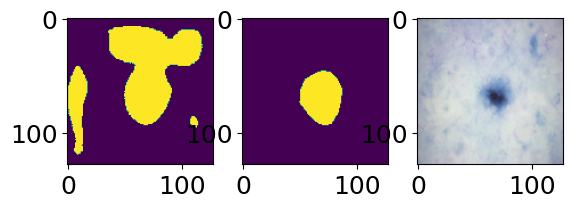

In [ ]:
plt.subplot(1, 3, 1)
plt.imshow(pred)
plt.subplot(1, 3, 2)
plt.imshow(label)
plt.subplot(1, 3, 3)
plt.imshow(img)

In [ ]:
def iou(predictions, masks):
    intersection = np.logical_and(predictions, masks)
    union = np.logical_or(predictions, masks)
    iou = np.sum(intersection) / np.sum(union)
    return iou


## Data fitting types: Underfitting, overfitting, the fundamental trade-off

### Types of errors

Imagine that your train and validation errors do not align with each other. How do you diagnose the problem?  

We're going to think about 4 types of errors:

- $E_\textrm{train}$ is your training error (or mean train error from cross-validation).
- $E_\textrm{valid}$ is your validation error (or mean validation error from cross-validation).
- $E_\textrm{test}$ is your test error.
- $E_\textrm{best}$ is the best possible error you could get for a given problem.

### Underfitting

In [ ]:
df = pd.read_csv("data/canada_usa_cities.csv")
X = df.drop(columns=["country"])
y = df["country"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [ ]:
model = DecisionTreeClassifier(max_depth=1)  # decision stump
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
print("Train error:   %0.3f" % (1 - np.mean(scores["train_score"])))
print("Validation error:   %0.3f" % (1 - np.mean(scores["test_score"])))

Train error:   0.188
Validation error:   0.212


- If your model is too simple, like `DummyClassifier` or `DecisionTreeClassifier` with `max_depth=1`, it's not going to pick up on some random quirks in the data but it won't even capture useful patterns in the training data.
- The model won't be very good in general. Both train and validation errors would be high. This is **underfitting**.
- The gap between train and validation error is going to be lower.
- $E_\textrm{best} \lt E_\textrm{train} \lesssim E_\textrm{valid}$

### Overfitting

In [ ]:
model = DecisionTreeClassifier(max_depth=None)
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
print("Train error:   %0.3f" % (1 - np.mean(scores["train_score"])))
print("Validation error:   %0.3f" % (1 - np.mean(scores["test_score"])))

Train error:   0.000
Validation error:   0.213


- If your model is very complex, like a `DecisionTreeClassifier(max_depth=None)`, then you will learn unreliable patterns in order to get every single training example correct.
- The training error is going to be very low but there will be a big gap between the training error and the validation error. This is **overfitting**.
- In overfitting scenario, usually we'll see:
$E_\textrm{train} \lt E_\textrm{best}  \lt E_\textrm{valid}$
- In general, if $E_\textrm{train}$ is low, we are likely to be in the overfitting scenario. It is fairly common to have at least a bit of this.

- So the validation error does not necessarily decrease with the training error.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
results_dict = {
    "depth": [],
    "mean_train_error": [],
    "mean_cv_error": [],
    "std_cv_error": [],
    "std_train_error": [],
}
param_grid = {"max_depth": np.arange(1, 16)}

for depth in param_grid["max_depth"]:
    model = DecisionTreeClassifier(max_depth=depth)
    scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    results_dict["depth"].append(depth)
    results_dict["mean_cv_error"].append(1 - np.mean(scores["test_score"]))
    results_dict["mean_train_error"].append(1 - np.mean(scores["train_score"]))
    results_dict["std_cv_error"].append(scores["test_score"].std())
    results_dict["std_train_error"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict)
results_df = results_df.set_index("depth")

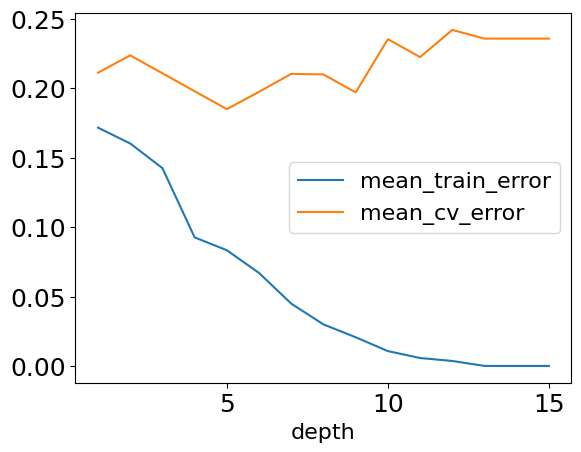

In [ ]:
results_df[["mean_train_error", "mean_cv_error"]].plot();

- Here, for larger depths we observe that the training error is close to 0 but validation error goes up and down.
- As we make more complex models we start encoding random quirks in the data, which are not grounded in reality.  
- These random quirks do not generalize well to new data.
- This problem of failing to be able to generalize to the validation data or test data is called **overfitting**.

### The "fundamental tradeoff" of supervised learning:


**As you increase model complexity, $E_\textrm{train}$ tends to go down but $E_\textrm{valid}-E_\textrm{train}$ tends to go up.**


### Bias vs variance tradeoff

- The fundamental trade-off is also called the bias/variance tradeoff in supervised machine learning.

**Bias**
: the tendency to consistently learn the same wrong thing (high bias corresponds to underfitting)

**Variance**
: the tendency to learn random things irrespective of the real signal (high variance corresponds to overfitting)


Check out [this article by Pedro Domingos](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) for some approachable explanation on machine learning fundamentals and bias-variance tradeoff.


### How to pick a model that would generalize better?

- We want to avoid both underfitting and overfitting.
- We want to be consistent with the training data but we don't to rely too much on it.

<!-- <center>
<img src='img/malp_0201.png' width="800" height="800" />
</center>    
 -->
![](img/malp_0201.png)

[source](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch02.html#relation-of-model-complexity-to-dataset-size)